In [99]:
import tensorflow as tf 
import numpy as np 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
import scipy.io as sio
from matplotlib import cm
from tensorflow import keras 
from tensorflow.keras import layers

from vehicle_model_DDPG1 import Environment 
from cell_model import CellModel 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

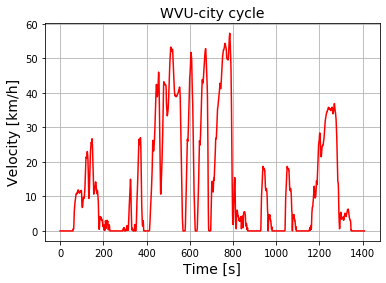

In [20]:
def plot_cycle(cycle_path, title):
    drv_cycle = sio.loadmat(cycle_path)
    v_veh = drv_cycle["sch_cycle"][:, 1] * 3.6
    
    plt.plot(v_veh, "r")
    plt.grid() 
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("Velocity [km/h]", fontsize=14)
    plt.title(title, fontsize=14)
    plt.savefig("cycle_images/{}.png".format(title))
    
    
plot_cycle("../../data/driving_cycles/city/wvucity.mat", "WVU-city cycle")


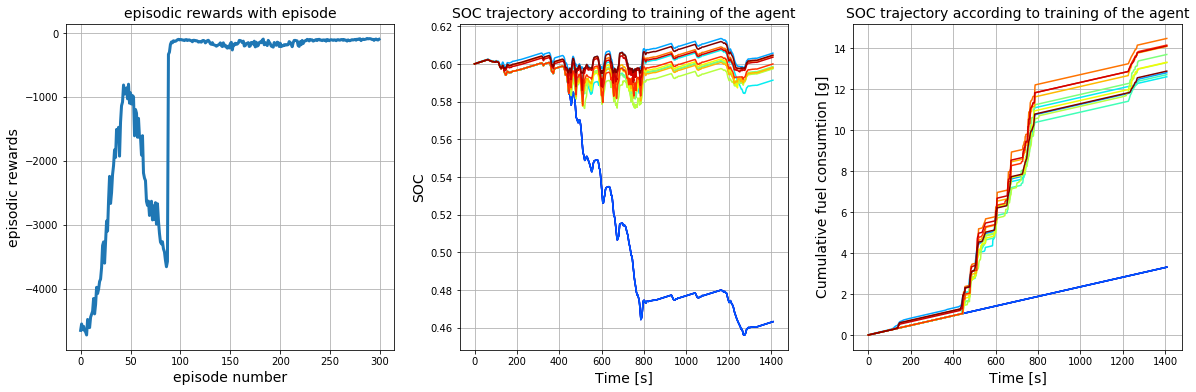

In [76]:
with open("DDPG1.pkl", "rb") as f: 
    DDPG1 = pickle.load(f)[1]
with open("DDPG2.pkl", "rb") as f: 
    DDPG2 = pickle.load(f)[1]
with open("DDPG3.pkl", "rb") as f: 
    DDPG3 = pickle.load(f)[1]
# with open("DDPG4.pkl", "rb") as f: 
#     DDPG4 = pickle.load(f)[1]

def visualization_test_data(data_dict, freq): 
    rewards = DDPG1["rewards"]
    
    env_histories = data_dict["test_history"]
    test_ids = data_dict["test_episode_num"]
    cm_subsection = np.linspace(0.0, 1.0, len(env_histories)//2)
    colors = [cm.jet(x) for x in cm_subsection]
    
    FC_trajectories = [] 
    SOC_trajectories = [] 
    action_trajectories = [] 
    for i, env_history in enumerate(env_histories): 
        if i % freq == 0: 
            SOC_trajectory = env_history["SOC"]
            FC_trajectory = env_history["m_fuel"]
            action_trajectory = env_history["Action"]
            
            SOC_trajectories.append(SOC_trajectory)
            FC_trajectory = np.cumsum(FC_trajectory)
            FC_trajectories.append(FC_trajectory)
            action_trajectories.append(action_trajectory)
    
#     for FC_trajectory, c in zip (FC_trajectories, colors): 
#         plt.plot(FC_trajectory, color=c)
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(rewards, linewidth=3)
    plt.grid() 
    plt.title("episodic rewards with episode", fontsize=14)
    plt.xlabel("episode number", fontsize=14)
    plt.ylabel("episodic rewards", fontsize=14)
    
    plt.subplot(1, 3, 2)
    i = 0 
    for SOC_trajectory, c in zip (SOC_trajectories, colors): 
        plt.plot(SOC_trajectory, color=c, label="agent at episode{}".format(test_ids[i]))
        i += 1 
    plt.grid() 
    plt.title("SOC trajectory according to training of the agent", 
             fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("SOC", fontsize=14)
    
    plt.subplot(1, 3, 3)
    for FC_trajectory, c in zip (FC_trajectories, colors): 
        plt.plot(FC_trajectory, color=c)
    plt.grid() 
    plt.title("SOC trajectory according to training of the agent", 
             fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("Cumulative fuel consumtion [g]", fontsize=14)
    
    plt.savefig("./generalization_confirmation/rewards_SOC_FC.png")
#     plt.clim((test_ids[0], test_ids[-1]))
#     plt.colorbar() 
#     plt.show() 

    
    
visualization_test_data(DDPG1, 2)

# DDPG와 DDQN의 일반화 성능 비교 

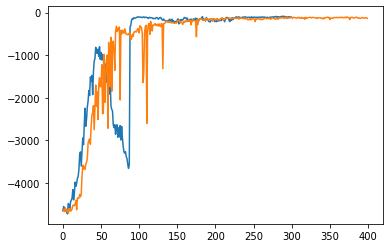

In [78]:
with open("DDPG1.pkl", "rb") as f: 
    DDPG1 = pickle.load(f)[1]
    
with open("DDQN1.pkl", "rb") as f: 
    DDQN1 = pickle.load(f)[10]
    
rewards_DDPG = DDPG1["rewards"]
rewards_DDQN = DDQN1["rewards"]

plt.plot(rewards_DDPG)
plt.plot(rewards_DDQN)
plt.show() 


# 다양한 테스트 사이클에 대한 검증 

In [100]:
drving_cycle = '../../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)

In [101]:
num_states = 4

In [102]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    
    
actor_model = get_actor() 

In [103]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [108]:
def test_and_visualization(model_path, driving_path, cycle_name): 
    env = Environment(cell_model, driving_path, battery_path, motor_path, 10)
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
        
    v_veh = env.v_veh * 3.6 
    SOC_traj = env.history["SOC"]
    FC_traj = env.history["m_fuel"]
    FC_traj_cumsum = np.cumsum(FC_traj)
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(v_veh, linewidth=3)
    plt.grid() 
    plt.title(cycle_name, fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("Velocity [km/h]", fontsize=14)
    
    plt.subplot(1, 3, 2)
    plt.plot(SOC_traj, linewidth=3)
    plt.grid() 
    plt.title("SOC trajectory", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("SOC", fontsize=14)
    
    plt.subplot(1, 3, 3)
    plt.plot(FC_traj_cumsum, linewidth=3)
    plt.grid() 
    plt.title("Cumulative fuel consumption", fontsize=14)
    plt.xlabel("Time [s]", fontsize=14)
    plt.ylabel("Cumulative fuel consumtion [g]", fontsize=14)
    
    plt.savefig("./result_images/validation_with_{}.png".format(cycle_name))

maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -59.79515510999877 SOC: 0.6065 Cumulative_SOC_deviation: 3.4093 Fuel Consumption: 25.7025
******************* Test is done *****************



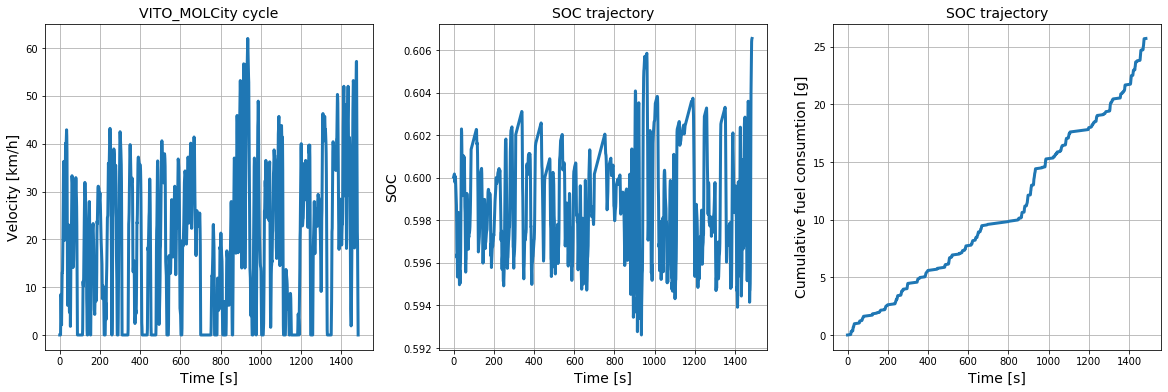

In [112]:
model_path = "./DDPG1_trial1/actor_model_checkpoint" 

driving_path = '../../data/driving_cycles/city/VITO_MOLCity.mat'

env = test_and_visualization(model_path, driving_path, "VITO_MOLCity cycle")


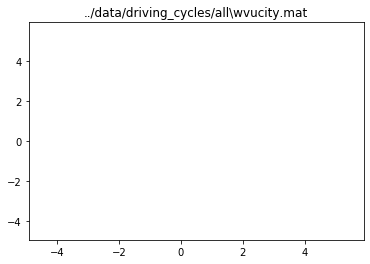

In [13]:
import glob 

driving_cycle_paths = glob.glob("../data/driving_cycles/all/*.mat")

for path in driving_cycle_paths: 
    plt.plot()
    plt.title(path)
    
plt.show() 
